# Interpret the results on mouse brain data

In [1]:
import torch

# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: False


In [ ]:

import os
import sys
sys.path.append("../")
if torch.cuda.is_available():
    device = "cuda"
    print(torch.cuda.get_device_name(0))
else:
    device = "cpu"
    print("Using CPU")


Using CPU


In [3]:
import scanpy as sc
import squidpy as sq
import pandas as pd
from tqdm.notebook import tqdm
import scipy as sp
import numpy as np
import multiprocessing
import pickle as pkl
import torch
import gc
import sklearn.metrics

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'arial'

pltkw = dict(bbox_inches='tight', transparent=True)

c:\Users\User\anaconda3\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\spatialdata\_core\query\relational_query.py:532: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left = partial(_left_join_spatialelement_table)
c:\Users\User\anaconda3\Lib\site-packages\spatialdata\_core\query\relational_query.py:533: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left_exclusive = partial(_left_exclusive_join_spatialelement_table)
c:\Users\User\anaconda3\Lib\site-packages

In [4]:
import steamboat as sf
import steamboat.tools
# importlib.reload(spaceformer.benchmarks)

## Astro-Epen in different regions

In [5]:
saved_h5ad_path = "G:/My Drive/Thesis/Projects/Data/Steamboat_Data/saved_h5ad/mmbrain"

In [6]:
# Load the annotated dataset by our model .
adata = sc.read_h5ad(f"{saved_h5ad_path}/mmbrain_0.h5ad")

# Normalize and standardize gene expression values so that each gene
# has mean = 0 and variance = 1 (important for PCA and clustering).
sc.pp.scale(adata)

# Perform Principal Component Analysis (PCA) on the scaled data
# to reduce dimensionality and capture the main sources of variation.
sc.pp.pca(adata)

# Compute a k-nearest neighbors graph of cells in the PCA space.
sc.pp.neighbors(adata)

# Compute a UMAP (Uniform Manifold Approximation and Projection) embedding.
sc.tl.umap(adata)

c:\Users\User\anaconda3\Lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


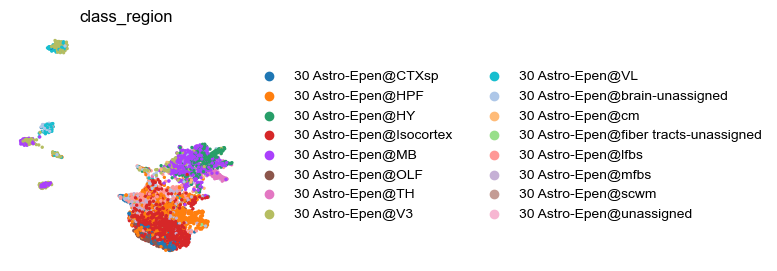

In [7]:
# Create a new column 'class_region' in the observation metadata (adata.obs).
# It combines 'class' and 'parcellation_division' columns into a single string
# with the format "class@parcellation_division".
adata.obs['class_region'] = adata.obs['class'].astype(str) + '@' + adata.obs['parcellation_division'].astype(str)

# Subset the AnnData object to only include cells where 'class' is "30 Astro-Epen".
# This creates a new AnnData object containing only astrocyte and ependymal cells.
astro_adata = adata[adata.obs['class'] == '30 Astro-Epen']

# Initialize a matplotlib figure and axes with a small size (3x3 inches).
# We'll use this axis to plot the UMAP embedding.
fig, ax = plt.subplots(figsize=(3, 3))

# --- Run the analysis pipeline again, but only on the astrocyte subset ---

# Standardize gene expression (mean = 0, variance = 1) within the subset.
sc.pp.scale(astro_adata)

# Perform PCA on the subset to reduce dimensionality.
sc.pp.pca(astro_adata)

# Construct a k-nearest neighbors graph in PCA space for the subset.
sc.pp.neighbors(astro_adata)

# Compute the UMAP embedding (2D representation) for the astrocyte subset.
sc.tl.umap(astro_adata)

# Plot the UMAP embedding, coloring cells by the 'class_region' column.
# The plot is drawn on the axis 'ax', and frameon=False removes the axis frame.
sc.pl.umap(astro_adata, color=['class_region'], ax=ax, frameon=False)

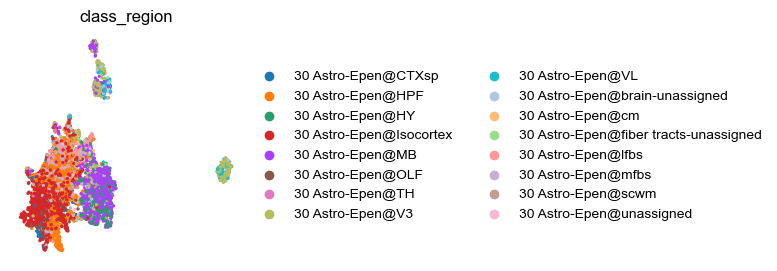

In [8]:
# Subset the dataset to only astrocyte/ependymal cells ("30 Astro-Epen").
astro_adata = adata[adata.obs['class'] == '30 Astro-Epen']

# Create a matplotlib figure (3x3 inches) to display the UMAP plot.
fig, ax = plt.subplots(figsize=(3, 3))

# Create a new AnnData object where the main data matrix (X) is replaced
# with the precomputed embedding stored in obsm['attn'].
# The cell metadata (obs) is kept the same, so we can still access 'class_region'.
astro_adata = sc.AnnData(astro_adata.obsm['attn'], obs=astro_adata.obs)

# Standardize the embedding features (mean=0, variance=1).
sc.pp.scale(astro_adata)

# Build a k-nearest neighbors graph using the 'attn' embedding space.
sc.pp.neighbors(astro_adata)

# Compute a 2D UMAP embedding from the neighbors graph.
sc.tl.umap(astro_adata)

# Plot the UMAP embedding, coloring cells by 'class_region'.
# The plot is drawn on the pre-defined axis, and the frame is removed for a clean look.
sc.pl.umap(astro_adata, color=['class_region'], ax=ax, frameon=False)

# (Optional) Save the figure as a PDF file with tight bounding box.
# fig.savefig(savefig_path + "astro_epen_region.pdf", bbox_inches='tight')


In [12]:
adatas = [sc.read_h5ad(f"{saved_h5ad_path}/mmbrain_0.h5ad")]

## Head weights

In [ ]:
# savefig_path = "C:/Users/lshh/OneDrive/Publications/Steamboat/pub/fig-merfish-elements/"
import importlib
importlib.reload(steamboat.tools)

<module 'steamboat.tools' from 'C:\\Users\\User\\PycharmProjects\\Steamboat\\steamboat\\tools.py'>

In [9]:
model = sf.Steamboat(adata.var_names.tolist(), n_heads=50, n_scales=3)
model = model.to(device)


In [ ]:
##working with google colab
model.load_state_dict(torch.load('saved_models/mmbrain_new.pth', weights_only=True), strict=False)

In [23]:
##working with laptop
model.load_state_dict(torch.load('saved_models/mmbrain_new.pth', map_location=torch.device('cpu'),weights_only=True))

<All keys matched successfully>

Using ['global'] as regional annotations.


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


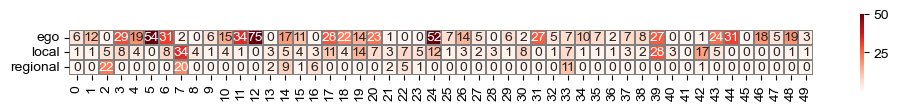

In [24]:
## For simplicity, we only visualize the weights from one slide here, not all of them.
dataset = sf.make_dataset(adatas, regional_obs=['global'])
sf.tools.calc_obs(adatas, dataset, model)
head_weights = sf.tools.calc_head_weights(device, adatas, model)
sf.tools.plot_head_weights(head_weights, figsize=(12, 1), multiplier=1000, heatmap_kwargs={'vmax': 50})

c:\Users\User\anaconda3\Lib\site-packages\squidpy\pl\_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


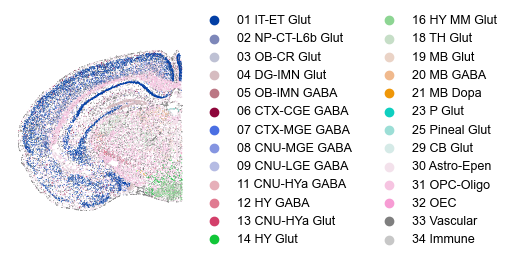

In [14]:
sq.pl.spatial_scatter(adatas[0], color='class', shape=None, figsize=(5, 5), size=1., lw=0.0, legend_fontsize=9, title="", frameon=False)
# plt.savefig(savefig_path + "mmbrain_spatial.png", dpi=200, bbox_inches='tight')

c:\Users\User\anaconda3\Lib\site-packages\squidpy\pl\_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


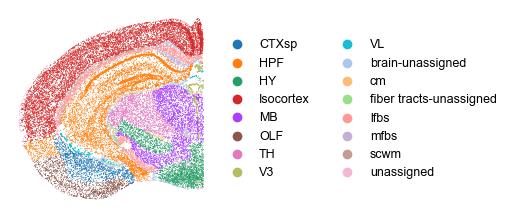

In [15]:
sq.pl.spatial_scatter(adatas[0], color='parcellation_division', shape=None, figsize=(5, 5), size=1., lw=0.0, legend_fontsize=9, title="", frameon=False)
# plt.savefig("figures/mmbrain_division_spatial.png", dpi=200, bbox_inches='tight')

In [28]:
adatas[0].obsm.keys()

KeysView(AxisArrays with keys: X_recon, attn, ego_attn, k_score, k_score_global, local_attn, q_score, regional_attn_0, spatial, q, local_k, global_k_0, global_attn_0)

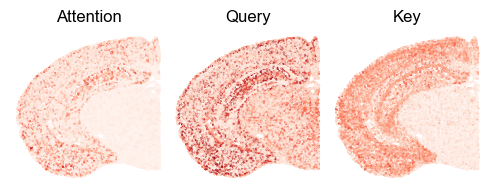

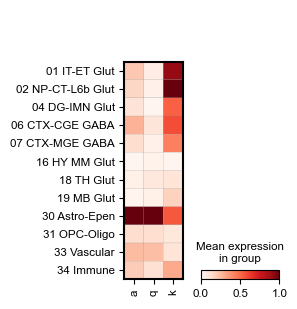

In [26]:
for i_head in range(24, 25): ## Change this to see more
    adatas[0].obs['a'] = adatas[0].obsm['local_attn'][:, i_head]
    adatas[0].obs['q'] = adatas[0].obsm['q'][:, i_head]
    adatas[0].obs['k'] = adatas[0].obsm['local_k'][:, i_head]

    sq.pl.spatial_scatter(adatas[0], color=['a', 'q', 'k'], shape=None, figsize=(2, 2), size=.25,
                          legend_fontsize=9, cmap='Reds', ncols=3, colorbar=False, vmin=0., wspace=.0, outline=False, frameon=False, title=['Attention', 'Query', 'Key'])
    # plt.savefig(savefig_path + f"mmbrain_factor{i_comp}.png", dpi=200, transparent=False, bbox_inches='tight')

    temp_adata = adatas[0].copy()
    good_classes = adatas[0].obs['class'].value_counts()
    good_classes = good_classes[good_classes > temp_adata.shape[0] * 0.01].index.to_list()
    temp_adata = temp_adata[temp_adata.obs['class'].isin(good_classes)]

    fig, ax = plt.subplots(figsize=(2, 3.5))
    sc.pl.matrixplot(temp_adata, ['a', 'q', 'k'], 'class', standard_scale='var', ax=ax, cmap='Reds')
    # fig.savefig(savefig_path + f"mmbrain_factor{i_comp}_dot.pdf", transparent=False, bbox_inches='tight')

## Clustering and spatial domain segmentaiton

In [ ]:
sf.tools.neighbors(adata, 'attn')  #compute a neighborhood graph on attention embeddings
sf.tools.leiden(adata, resolution=1.)  #clustering cells using the Leiden algorithm

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


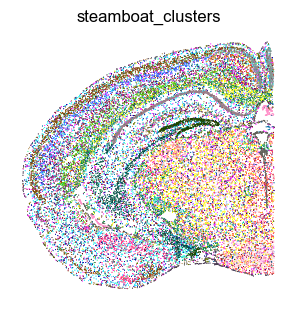

In [ ]:
sq.pl.spatial_scatter(adata, color=['steamboat_clusters'], shape=None, figsize=(3, 3), ncols=2, legend_loc=None, frameon=False,
                                    size=2., lw=0.,
                      wspace=0.0, hspace=0.0)

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


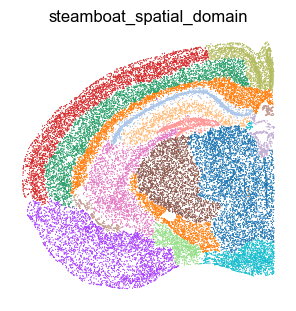

In [ ]:
sf.tools.segment(adata, resolution=0.8)
sq.pl.spatial_scatter(adata, color=['steamboat_spatial_domain'], shape=None, figsize=(3, 3), ncols=2, legend_loc=None, frameon=False,
                                    size=2., lw=0.,
                      wspace=0.0, hspace=0.0)

## Ligand-receptor analysis

In [ ]:
import re

lrdb = pd.read_csv("E:/allen-brain-cell-atlas/aux_data/CellChatDB.mouse.csv", index_col=0)
lrdb

def parse_complex(s):
    if s[0] != '(':
        return [s]
    else:
        return s[1:-1].split('+')

def parse_lr(s):
    l, r = s.split(' - ')
    return parse_complex(l), parse_complex(r)

lrp = []
for i in lrdb['interaction_name_2']:
    ls, rs = parse_lr(i)
    for l in ls:
        for r in rs:
            lrp.append((l.strip(), r.strip()))

n_heads = 50

k_local = model.spatial_gather.k_local.weight.detach().cpu().numpy()
k_global = model.spatial_gather.k_regionals[0].weight.detach().cpu().numpy()
q = model.spatial_gather.q.weight.detach().cpu().numpy()
v = model.spatial_gather.v.weight.detach().cpu().numpy().T

adata = sc.read_h5ad(f"saved_h5ad/mmbrain_{0}.h5ad")

index = ([f'k_local_{i}' for i in range(n_heads)] +
         [f'k_global_{i}' for i in range(n_heads)] +
         [f'q_{i}' for i in range(n_heads)] +
         [f'v_{i}' for i in range(n_heads)])
gene_df = pd.DataFrame(np.vstack([k_local, k_global, q, v]),
                       index=index, columns=adata.var['gene_symbol']).T

normalized_gene_df = gene_df.multiply(adata.X.mean(axis=0), axis=0)
normalized_gene_df /= normalized_gene_df.max(axis=0)
lrp_dfs = []
for i in tqdm(range(n_heads)):
    lrp_df = pd.DataFrame(lrp, columns=['ligand', 'receptor'])
    lrp_df = lrp_df.drop_duplicates()
    lrp_df['lr'] = lrp_df['ligand'] + '-' + lrp_df['receptor']
    lrp_df = lrp_df[(lrp_df['ligand'].isin(adata.var['gene_symbol'].values)) & (lrp_df['receptor'].isin(adata.var['gene_symbol'].values))]

    lrp_df['kl_score'] = np.log(normalized_gene_df.loc[lrp_df['ligand'].tolist(), f'k_local_{i}'].tolist())
    lrp_df['qr_score'] = np.log(normalized_gene_df.loc[lrp_df['receptor'].tolist(), f'q_{i}'].tolist())
    lrp_df['lr_score'] = lrp_df['kl_score'] + lrp_df['qr_score']

    lrp_df['ql_score'] = np.log(normalized_gene_df.loc[lrp_df['ligand'].tolist(), f'q_{i}'].tolist())
    lrp_df['kr_score'] = np.log(normalized_gene_df.loc[lrp_df['receptor'].tolist(), f'k_local_{i}'].tolist())
    lrp_df['rl_score'] = lrp_df['kr_score'] + lrp_df['ql_score']

    lrp_df['k_to_q'] = lrp_df['lr_score'] > lrp_df['rl_score']

    lrp_df['score'] = np.maximum(lrp_df['lr_score'], lrp_df['rl_score'])

    xy = np.maximum((lrp_df['kl_score'].to_numpy() + lrp_df['qr_score'].to_numpy()[:, None]).flatten(),
                    (lrp_df['kr_score'].to_numpy() + lrp_df['ql_score'].to_numpy()[:, None]).flatten())
    lrp_df['p'] = (lrp_df['score'].to_numpy()[:, None] < xy).sum(axis=1) / len(xy)

    # xy = (lrp_df['kl_score'].to_numpy() + lrp_df['qr_score'].to_numpy()[:, None]).flatten(),
    # lrp_df['p_lr'] = (lrp_df['lr_score'].to_numpy()[:, None] < xy).sum(axis=1) / len(xy)

    # lrp_df['p_rl'] = float('nan')
    # xy = np.maximum((lrp_df['kl_score'].to_numpy() + lrp_df['qr_score'].to_numpy()[:, None]).flatten(),
    #                 (lrp_df['kr_score'].to_numpy() + lrp_df['ql_score'].to_numpy()[:, None]).flatten())

    # lrp_df['p'] = (lrp_df['lr_score'].to_numpy()[:, None] < xy).sum(axis=1) / len(xy)

    lrp_df['adj_p'] = sp.stats.false_discovery_control(lrp_df['p'])

    lrp_dfs.append(lrp_df.sort_values('p'))

lrp_dfs[5][lrp_dfs[5]['p'] < 0.05]

  0%|          | 0/50 [00:00<?, ?it/s]

,ligand,receptor,lr,kl_score,qr_score,lr_score,ql_score,kr_score,rl_score,k_to_q,score,p,adj_p
2579,Cldn11,Cldn11,Cldn11-Cldn11,-7.451209,-0.779319,-8.230528,-0.779319,-7.451209,-8.230528,False,-8.230528,0.000000,0.000000
444,Wnt4,Fzd5,Wnt4-Fzd5,-10.823726,-5.461134,-16.284859,-14.276980,-13.275460,-27.552441,True,-16.284859,0.039257,0.883598
919,Wnt5a,Fzd5,Wnt5a-Fzd5,-10.941229,-5.461134,-16.402363,-10.562279,-13.275460,-23.837739,True,-16.402363,0.040391,0.883598


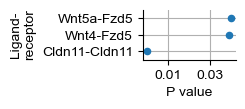

In [ ]:
fig, ax = plt.subplots(figsize=(1.2, 0.65))
lrp_dfs[5][lrp_dfs[5]['p'] < 0.05].plot.scatter(y='lr', x='p',  ax=ax)
ax.set_xticks([0.01, 0.03])
ax.set_ylabel('Ligand-\nreceptor')
ax.set_xlabel('P value')
for pos in ['right', 'top']:
    ax.spines[pos].set_visible(False)
ax.set_ylim([-0.5, 2.5])
ax.set_axisbelow(True)
ax.grid(axis='both', zorder=0)

C:\Users\lshh\AppData\Local\Temp\ipykernel_113232\3305993158.py:14: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f'{l}-{r}_colors'] = [color_map[i] for i in adata.obs[f'{l}-{r}'].cat.categories]


C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
C:\Users\lshh\AppData\Local\Temp\ipykernel_113232\3305993158.py:14: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f'{l}-{r}_colors'] = [color_map[i] for i in adata.obs[f'{l}-{r}'].cat.categories]


C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
C:\Users\lshh\AppData\Local\Temp\ipykernel_113232\3305993158.py:14: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f'{l}-{r}_colors'] = [color_map[i] for i in adata.obs[f'{l}-{r}'].cat.categories]


C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


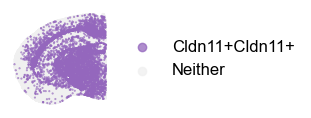

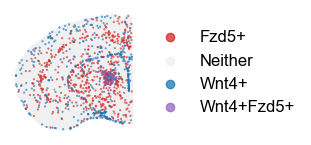

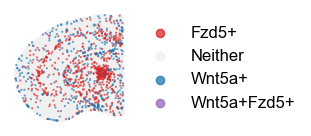

In [ ]:
def plot_lr(adata, l, r, l_cutoff=0, r_cutoff=0, figsize=(10, 10)):
    adata.obs[f'{l}-{r}'] = ''
    adata.obs.loc[(adata[:, l].X > l_cutoff).squeeze(), f'{l}-{r}'] += f'{l}+'
    adata.obs.loc[(adata[:, r].X > r_cutoff).squeeze(), f'{l}-{r}'] += f'{r}+'
    adata.obs.loc[adata.obs[f'{l}-{r}'] == '', f'{l}-{r}'] = 'Neither'
    adata.uns[f'{l}-{r}_colors'] = {'#f0f0f0', 'C0', 'C3', 'C4'}
    adata.obs[f'{l}-{r}'] = adata.obs[f'{l}-{r}'].astype('category')

    any = adata.obs_names[adata.obs[f'{l}-{r}'] != 'Neither'].tolist()
    neither = adata.obs_names[adata.obs[f'{l}-{r}'] == 'Neither'].tolist()

    adata = adata[neither + any, :]
    color_map = {'Neither': '#f0f0f0', f'{l}+': 'C0', f'{r}+': 'C3', f'{l}+{r}+': 'C4'}
    adata.uns[f'{l}-{r}_colors'] = [color_map[i] for i in adata.obs[f'{l}-{r}'].cat.categories]
    sq.pl.spatial_scatter(adata, color=[f'{l}-{r}'], shape=None, figsize=figsize, size=1.,
                          legend_fontsize=12, na_color='#f0f0f0', frameon=False, title='', alpha=.75, outline=False)

adata.var_names = adata.var['gene_symbol']

for i in lrp_dfs[5][lrp_dfs[5]['p'] < 0.05].index:
    plot_lr(adata, l=lrp_dfs[5].loc[i, 'ligand'], r=lrp_dfs[24].loc[i, 'receptor'], figsize=(3, 2), l_cutoff=.75, r_cutoff=.75)

## Interpretation of global attention
The global sample score of head 2 is correlated with the z-coordinate of slides.

In [30]:
# Global
glb = []
z = []
donor = []
for i in range(129):
    adata = sc.read_h5ad(f"{saved_h5ad_path}/mmbrain_{i}.h5ad")
    glb.append(adata.uns['embk_0'][0, 2])
    z.append(adata.obs['z'].unique().item())
    donor.append(adata.obs['donor_label'].astype(str).unique().item())

KeyError: "Unable to synchronously open object (file read failed: time = Fri Sep 26 23:33:35 2025\n, filename = 'G:/My Drive/Thesis/Projects/Data/Steamboat_Data/saved_h5ad/mmbrain/mmbrain_58.h5ad', file descriptor = 4, errno = 22, error message = 'Invalid argument', buf = 000002950AF10120, total read size = 512, bytes this sub-read = 512, offset = 269766128)"

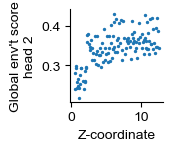

In [ ]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
plt.scatter(z, glb, s=2.)
for pos in ['right', 'top']:
    ax.spines[pos].set_visible(False)
ax.set_xlabel('Z-coordinate')
ax.set_ylabel("Global env't score\nhead 2")
# fig.savefig(savefig_path + f"zcoord.pdf", transparent=False, bbox_inches='tight')

In [ ]:
sp.stats.pearsonr(z, glb)

PearsonRResult(statistic=0.6239899360006265, pvalue=2.7930769923832913e-15)